<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 09. PyTorch Model Deployment

Welcome to Milestone Project 3: PyTorch Model Deployment!

**Status:** Work in progress.

Goal: Take FoodVision Mini model and make it publically accessible (deploy it to a usable app/interface), want it to be:
* Fast (a slow app is a boring app)
* Good (95%+ accuracy for 3 classes but this would be harder to achieve with more classes)

--
* TK - What is model deployment?
    * TK - PyTorch workflow + model deployment... (another step)
* TK - Why deploy a machine learning model?
* TK - Batch vs real-time (online -> real-time vs offline -> batch)
    * Model deployment trade off: Do you pick a model that works at 95% of performance that has an inference time of 1 second or a model that works at 98% but takes 10 seconds per inference? 
* TK - On edge vs on cloud
* TK - What to do when your model is deployed? E.g. monitoring? 
    * TK - Perhaps talk about this when the model is actually deployed
    * TK - What could go wrong when a model is deployed?
* TK - Creating a demo (what are the inputs and outputs)...
    * TK - Describing a machine learning problem... one of the best ways is in inputs and outputs, "what are your ideal inputs and ideal outputs?"

## TK - What we're going to cover 

## Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## 0. Getting setup 

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the [`pytorch-deep-learning` repository](https://github.com/mrdbourke/pytorch-deep-learning) (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using `torchvision` v0.13 package (available as of July 2022), we'll make sure we've got the latest versions.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.0+cu102
torchvision version: 0.13.0+cu102


> **Note:** If you're using Google Colab and the cell above starts to install various software packages, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` and `torchvision`.

Now we'll continue with the regular imports, setting up device agnostic code and this time we'll also get the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script from GitHub.

The `helper_functions.py` script contains several functions we created in previous sections:
* `set_seeds()` to set the random seeds (created in [07. PyTorch Experiment Tracking section 0](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#create-a-helper-function-to-set-seeds)).
* `download_data()` to download a data source given a link (created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data)).
* `plot_loss_curves()` to inspect our model's training results (created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0))

> **Note:** It may be a better idea for many of the functions in the `helper_functions.py` script to be merged into `going_modular/going_modular/utils.py`, perhaps that's an extension you'd like to try.


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Finally, we'll setup device-agnostic code to make sure our models run on the GPU.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK - 1. Getting data

We left off in [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size) comparing our own ViT (Vision Transformer) feature extractor model to the EfficientNetB2 (EffNetB2) feature extractor model we created in [07. PyTorch Experiment Tracking](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#9-load-in-the-best-model-and-make-predictions-with-it).

And we found that there was a slight difference in the comparison.

The EffNetB2 model was trained on 20% of the pizza, steak and sushi data from Food101 where as the ViT model was trained on 10%.

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the [20% pizza, steak and sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

This way we'll be comparing apples to apples.

> **Note:** The dataset we're downloading is a sample of the entire [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html#food101) (101 food classes with 1,000 images each). More specifically, 20% refers to 20% of images from the pizza, steak and sushi classes selected at random. You can see how this dataset was created in [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

Wonderful!

Now we've got a dataset, let's creat training and test paths.

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## TK - FoodVision Mini modelling experiment outline

The ideal deployed model FoodVision Mini performs well and fast.

Ideally, we'd like a model that performs as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's about how fast the human eye can see (there is debate on this but let's just use ~30FPS as our benchmark).

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy.

Of course, higher accuracy would be nice but this might sacrifice speed.

So our goals are:

1. A model that can classify an image at ~30FPS (0.03 seconds per image).
2. A model that performs at 95%+ accuracy.

To try and achieve these results, let's bring in our best performing models from the previous sections: 

1. EffNetB2 feature extractor - originally created in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models) using [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2) with adjusted `classifier` layers.
2. ViT-B/16 feature extractor - originally created in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset) using [`torchvision.models.vit_b_16`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#vit-b-16) with adjusted `head` layers. 

TK image - experiment outline (2 models, same dataset, same training regime)

> **Note:** A "feature extractor model" often starts with a model that has been pretrained on a dataset similar to your own problem. The pretrained model's base layers are often left frozen (the pretrained patterns/weights stay the same) whilst some of the top (or classifier/classification head) layers get customized to your own problem by training on your own data. We covered the concept of a feature extractor model in [06. PyTorch Transfer Learning section 3.4](https://www.learnpytorch.io/06_pytorch_transfer_learning/#34-freezing-the-base-model-and-changing-the-output-layer-to-suit-our-needs).

## TK - Creating an EffNetB2 feature extractor

We first created an EffNetB2 feature extractor model in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models).

And we saw by the end of that section it performed very well.

So let's now recreate it here so we can compare its results to a ViT feature extractor trained on the same data.

To do so we can:
1. Setup the pretrained weights as `torchvision.models.EfficientNet_B2_Weights.DEFAULT`, where "`DEFAULT`" means "best currently available" (or could use `weights="DEFAULT"`). 
2. Get the pretrained model image transforms from the weights with the `transforms()` method.
3. Create a pretrained model instance by passing the weights to an instance of `torchvision.models.efficientnet_b2`.
4. Freeze the base layers in the model.
5. Update the classifier head to suit our own data.

In [71]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in model.parameters():
    param.requires_grad = False

Now to change the classifier head, let's first inspect it using the `classifier` attribute of our model.

In [74]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

Excellent! To change the classifier head to suit our own problem, let's replace the `out_features` variable with the same number of classes we have (in our case, `out_features=3`, one for pizza, steak, sushi).

> **Note:** This process of changing the output layers/classifier head will be dependent on the problem you're working on. For example, if you wanted a different *number* of outputs or a different *kind* of ouput, you would have to change the output layers accordingly. 

In [75]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

Beautiful!

Looks like our EffNetB2 feature extractor is ready to go, however, since there's quite a few steps involved here, how about we turn the code above into a function we can re-use later?

We'll call it `create_effnetb2_model()` and it'll take a customizable number of classes and a random seed parameter for reproducibility.

Ideally, it will return an EffNetB2 feature extractor along with its assosciated transforms.

In [76]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates and EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model.
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    return model, transforms

Woohoo! That's a nice looking function, let's try it out.

In [77]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

No errors, nice, now to really try it out, let's get a summary with `torchinfo.summary()`. 

In [78]:
from torchinfo import summary
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Base layers frozen, top layers trainable and customized!

TK image - turn model summary into image

### TK - Create DataLoaders for EffNetB2 

Our EffNetB2 feature extractor is ready, time to create some `DataLoader`s.

UPTOHERE: detail the DataLoader creation...
* TK Where have we done this before? (plenty of places...)

In [8]:
# Setup dataloaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### TK - Train EffNetB2

In [9]:
# Train the model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9856 | train_acc: 0.5604 | test_loss: 0.7408 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7175 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9062 | test_loss: 0.4355 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3915 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4381 | train_acc: 0.8896 | test_loss: 0.3512 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3129 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688


### TK - Plot EffNetB2 loss curves 

* TK - Link to loss curves section: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like 

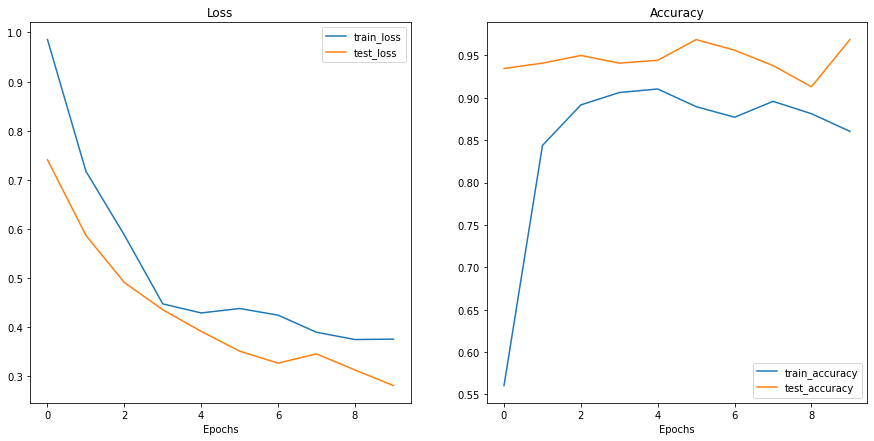

In [10]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### TK - Save EffNetB2 model

In [11]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [12]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### TK - Collect EffNetB2 stats

* TK - Want to compare our models later on... 

In [13]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.281286683678627, 'test_acc': 0.96875, 'model_size (MB)': 29}

## TK - Creating a ViT feature extractor

Source - https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16

In [14]:
def create_vit_model(num_classes: int=3, seed: int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)


    # Freeze base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, 
                                          out_features=len(class_names)))
    
    return model, transforms

vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

### TK - Create DataLoaders for ViT

In [15]:
# Setup dataloaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=vit_transforms,
                                                                                                 batch_size=32)


```
(heads): Sequential(
     (head): Linear(in_features=768, out_features=1000, bias=True)
   )
```

### TK - Train ViT

In [16]:
# Train the model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### TK - Plot ViT loss curves

* TK - see ideal loss curves here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

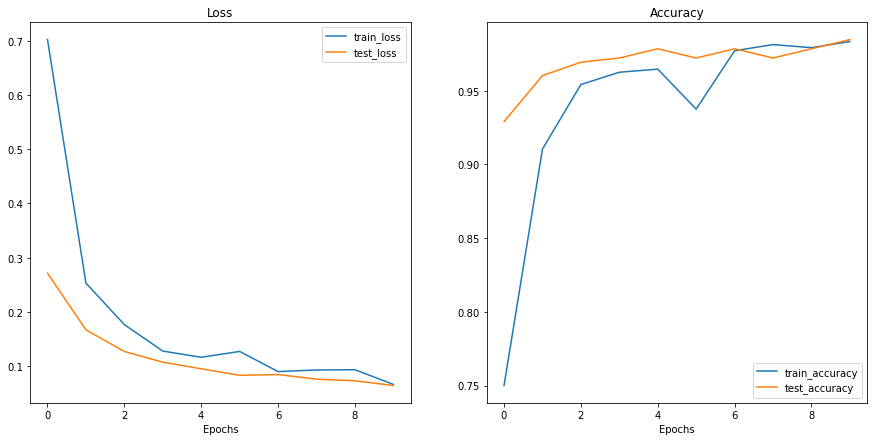

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [18]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [19]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [20]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06418213145807386,
 'test_acc': 0.984659090909091,
 'model_size (MB)': 327}

## TK - Making predictions with our trained models and timing them

* TK - want FoodVision Mini to be deployed and able to make predictions *fast*... real-time is good (e.g. 30 fps)
* TK - make predictions on the CPU because might not have access to a GPU

In [21]:
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer 

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        # Create empty dict to store info for each sample
        pred_dict = {}

        # Get sample path
        pred_dict["image_path"] = path

        # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Get prediction and prediction probability
        start_time = timer()
        img = Image.open(path) # open image
        transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # Make sure things in the dictionary are back on the CPU 
            pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict["pred_class"] = pred_class
            
            # Calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # print(pred_dict)
        # Add the dictionary to the list of preds
        test_pred_list.append(pred_dict)

    return test_pred_list

### TK - Make and time predictions with EffNetB2

In [22]:
effnetb2_test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

effnetb2_test_pred_dicts[:3]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9293267726898193,
  'pred_class': 'steak',
  'time_for_pred': 0.0552,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9533632397651672,
  'pred_class': 'steak',
  'time_for_pred': 0.0351,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7531499266624451,
  'pred_class': 'steak',
  'time_for_pred': 0.0343,
  'correct': True}]

### TK - Make and time predictions with ViT 

In [23]:
vit_test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

vit_test_pred_dicts[:3]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9932767748832703,
  'pred_class': 'steak',
  'time_for_pred': 0.1866,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9893474578857422,
  'pred_class': 'steak',
  'time_for_pred': 0.0638,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.997147262096405,
  'pred_class': 'steak',
  'time_for_pred': 0.0626,
  'correct': True}]

## TK - Compare model results, prediction times and size

In [24]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_average_time_per_pred = effnetb2_test_pred_df.time_for_pred.mean()
effnetb2_average_time_per_pred

0.028969333333333333

In [25]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.281286683678627,
 'test_acc': 0.96875,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.028969333333333333}

In [26]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_average_time_per_pred = vit_test_pred_df.time_for_pred.mean()
vit_average_time_per_pred

0.0646173333333333

In [27]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418213145807386,
 'test_acc': 0.984659090909091,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.0646173333333333}

In [28]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["effnetb2", "vit"]
df = df.set_index("model")
df

,test_loss,test_acc,model_size (MB),time_per_pred_cpu
model,,,,
effnetb2,0.281287,0.968750,29,0.028969
vit,0.064182,0.984659,327,0.064617


In [29]:
df.loc["vit"] / df.loc["effnetb2"]

test_loss             0.228173
test_acc              1.016422
model_size (MB)      11.275862
time_per_pred_cpu     2.230543
dtype: float64

## TK - Bringing FoodVision Mini to life by creating a Gradio demo

TK - Turn this into a script to save to file (e.g. save to `demos/foodvision_mini/xyz....py`)

In [30]:
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr

In [31]:
effnetb2.to("cpu") 
vit.to("cpu")

def predict(img):
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

Test prediction function.

In [32]:
import random
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]

print(random_image_path)
image = Image.open(random_image_path)
predict(img=image)

data/pizza_steak_sushi_20_percent/test/steak/864661.jpg


({'pizza': 0.30049753189086914,
  'steak': 0.40433385968208313,
  'sushi': 0.29516857862472534},
 0.04928)

In [33]:
test_dir

PosixPath('data/pizza_steak_sushi_20_percent/test')

In [34]:
example_list = [[str(filepath)] for filepath in random.sample(list(test_dir.glob("*/*.jpg")), k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/1383396.jpg']]

In [35]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7fb6d2b20430>, 'http://127.0.0.1:7860/', None)

## TK - Turning our FoodVision Mini Gradio Demo into a deployable app

Want all of Gradio demo in a single folder, e.g. `demos/foodvision_mini/some_file.py`...

In [36]:
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

In [37]:
# !rm -rf demos/foodvision_mini/foodvision_mini_images

In [38]:
# Create some examples
from pathlib import Path
import shutil

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [39]:
import os
examples_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
examples_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

In [40]:
!mv models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth demos/foodvision_mini/

In [41]:
%%writefile demos/foodvision_mini/model.py
import torchvision

from torch import nn


def create_effnetb2_model(num_classes: int):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    return model, transforms

Overwriting demos/foodvision_mini/model.py


In [42]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

# Setup class names
class_names = ["pizza", "steak", "sushi"]

# Create model
model, transforms = create_effnetb2_model(
    num_classes=3,
)

# Load saved weights
model.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

# Create prediction code
def predict(img):
    start_time = timer()
    img = transforms(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

# Create Gradio app
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=[["examples/" + example] for example in os.listdir("examples")],
    interpretation="default",
    title=title,
    description=description,
    article=article,
)

demo.launch()

Overwriting demos/foodvision_mini/app.py


In [43]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/foodvision_mini/requirements.txt


### TK - Download FoodVision Mini app files

In [44]:
# Zip foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

updating: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: app.py (deflated 49%)
updating: examples/ (stored 0%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/2582289.jpg (deflated 17%)
updating: flagged/ (stored 0%)
updating: model.py (deflated 46%)
updating: requirements.txt (deflated 4%)
Not running in Google Colab, can't use google.colab.files.download()


## TK - Deploying our FoodVision Mini app to HuggingFace Spaces

See the working deployed demo - https://huggingface.co/spaces/mrdbourke/foodvision_mini 


* TK - See here for uploading to HuggingFace spaces: https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories 
    * Upload manually: https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui 
    * Upload via terminal: https://huggingface.co/docs/hub/repositories-getting-started#terminal
* TK - requires git-lfs for larger model files (ours): https://git-lfs.github.com/ 

Steps for tracking larger model files: 
* Install git lfs
* Run `git lfs track "*.file_extension"` to track models, for example, `git lfs track "*.pth"`
* Track .gitattributes (automatically created when cloning from HuggingFace)- `git add .gitattributes`

## TK - Creating FoodVision Big

* Keep experiments quick... want something deployable that can classify with 100x different classes...
* Make a file with Gradio app demo in `demo/`, this can be uploaded to HuggingFace Spaces

In [45]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [46]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### TK - Getting data for FoodVision Big

> TK **Note:** If you're using Google Colab, the cell below will take ~5-10 minutes to fully run and download the Food101 images from PyTorch. This is because there is over 100,000 images being downloaded. If you restart your Google Colab runtime and come back to this cell, the images will have to redownload. Alternatively, if you're running this notebook locally, the images will be cached and stroed in the `root/` directory specified below. 

In [47]:
from torchvision import datasets
from torchvision import transforms

# Setup data directory
import pathlib
data_dir = pathlib.Path("data")

# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=train_transforms,
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

# Get class names
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [48]:
# UPTOHERE: Can split data into random splits with `random_split()`... https://pytorch.org/docs/stable/data.html
# Make 10% split and use for training data 
# Do the same with testing data, use these splits to train a bigger model and use that as "FoodVision Big"
def split_dataset(dataset, split_size:float=0.2, seed:int=42):
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2], 
                                                                   generator=torch.manual_seed(seed))
    return random_split_1, random_split_2

train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

In [49]:
import torch

BATCH_SIZE = 32
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=2)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=2)

### TK - Train big model

* TK - Train a model on all Food101 classes (20% of the data).
* TK - link to download the big model incase someone doesn't want to go through all the training process...

In [50]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, 
# see paper here: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf
# need 56.40% acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6411 | train_acc: 0.2814 | test_loss: 2.7810 | test_acc: 0.4947
Epoch: 2 | train_loss: 2.8608 | train_acc: 0.4421 | test_loss: 2.4720 | test_acc: 0.5355
Epoch: 3 | train_loss: 2.6546 | train_acc: 0.4862 | test_loss: 2.3634 | test_acc: 0.5612
Epoch: 4 | train_loss: 2.5434 | train_acc: 0.5125 | test_loss: 2.3020 | test_acc: 0.5765
Epoch: 5 | train_loss: 2.4951 | train_acc: 0.5236 | test_loss: 2.2794 | test_acc: 0.5796


### TK - Plot loss curves of the big model

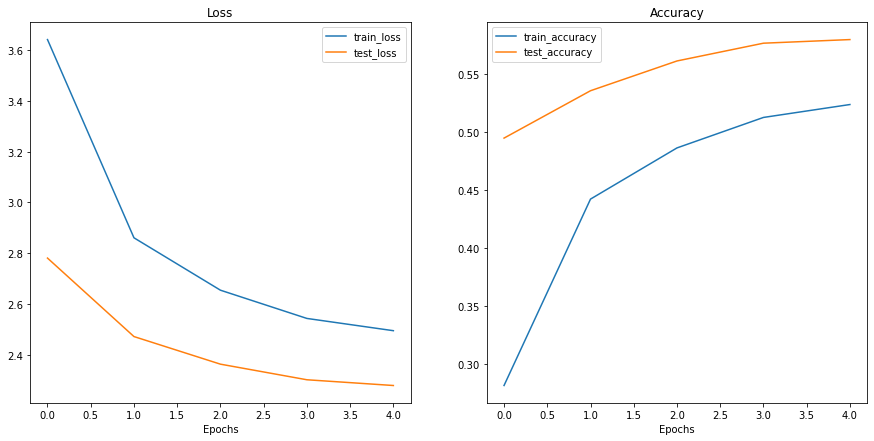

In [51]:
plot_loss_curves(effnetb2_food101_results)

### TK - Save big model

In [52]:
from going_modular.going_modular import utils

effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" 

utils.save_model(model=effnetb2_food101,
                 target_dir="models", # TK - could change this to save to the foodvision mini demo?
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


### TK - Load big model

In [53]:
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### TK - Check big model file size

In [54]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## TK - Turn big dog model into an app

TK - Add README.md to app folder

In [55]:
from pathlib import Path

foodvision_big_demo_path = Path("demos/foodvision_big/")
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

* TK - Make the code cell below cleaner 

In [56]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples

--2022-08-12 11:22:47--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: '04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  7.17MB/s    in 0.4s    

2022-08-12 11:22:48 (7.17 MB/s) - '04-pizza-dad.jpeg’ saved [2874848/2874848]



In [57]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

Save Food101 class names to file.

In [58]:
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

In [59]:
with open(foodvision_big_class_names_path, "w") as f:
    f.write("\n".join(food101_class_names)) 

In [60]:
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [61]:
%%writefile demos/foodvision_big/model.py
import torchvision

from torch import nn


def create_effnetb2_model(num_classes: int):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    return model, transforms

Overwriting demos/foodvision_big/model.py


* TK - add a list of classes that the model can classify to the app (e.g. a dropdown menu or a text file with all the class names

In [62]:
%%writefile demos/foodvision_big/app.py
import gradio as gr
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

# Setup class names
with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in  f.readlines()]

# Create model
model, transforms = create_effnetb2_model(
    num_classes=101,
)

# Load saved weights
model.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

# Create prediction code
def predict(img):
    start_time = timer()
    img = transforms(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time


# Create Gradio app
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into 101 different classes."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=[["examples/04-pizza-dad.jpeg"]],
    interpretation="default",
    title=title,
    description=description,
    article=article,
)

demo.launch()

Overwriting demos/foodvision_big/app.py


In [63]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/foodvision_big/requirements.txt


### TK - Download FoodVision Big app files

In [64]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

updating: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
updating: app.py (deflated 49%)
updating: class_names.txt (deflated 48%)
updating: examples/ (stored 0%)
updating: examples/04-pizza-dad.jpeg (deflated 0%)
updating: flagged/ (stored 0%)
updating: model.py (deflated 46%)
updating: requirements.txt (deflated 4%)
Not running in Google Colab, can't use google.colab.files.download()


## Deploying our FoodVision Big app to HuggingFace Spaces

See here for uploading to HuggingFace: https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories

See the deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_big/

## TK - Exercises
* Compare the model's prediction times on GPU vs CPU - does this close the gap?
* ViT seems to have more learning capacity than EffNetB2, how does it go on the larger Food101 dataset? - train for 5 epochs
    * Use same training setup as we've done for the EffNetB2 model

## TK - Extra-curriculum

* PyTorch blog for deploying on raspberry pi (on edge)
* Chapter 7 ML Systems Design
* Made with ML MLOps section
* Google's People + AI Guidebook (how to design applications that use AI) - https://pair.withgoogle.com/guidebook/ 
    * More on this covered in ML monthly April 2021 - https://zerotomastery.io/blog/machine-learning-monthly-april-2021/


### TK - Try `torch.jit`?

https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html

In [65]:
effnetb2_scripted = torch.jit.script(effnetb2)
vit_scripted = torch.jit.script(vit)
# effnetb2_scripted

### TK - How does `torch.jit` compare to non-jit? 